In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms

import numpy as np
from h5py import File
import matplotlib.pyplot as plt
from tqdm import tqdm

from torch.utils.data import DataLoader
from vis_utils import plot_time_series
import numpy as np

In [4]:
# define the transform function
trans = transforms.Compose([
    transforms.ToTensor(),
])

In [14]:
class H5Dataset(torch.utils.data.Dataset):
    def __init__(self, path: str,
                 response_type: str,
                 transform: transforms.Compose = trans,
                 train: bool= True):
        self.file_path = path
        # The available types are firing_rate_10ms, binned
        self.response_type = response_type
        self.X = None
        self.y = None
        self.transform = transform
        # Choose either train or test subsets
        self.data_type = "train" if train else "test"
        with File(self.file_path, 'r') as file:
            self.dataset_len = len(file[self.data_type]["stimulus"])

    def __getitem__(self, idx: int):
        if self.X is None or self.y is None:
            h5file = File(self.file_path, 'r')
            # Read as numpy array
            # TODO: see if there is a better way
            self.X = np.asarray(h5file[self.data_type]["stimulus"])
            self.y = np.asarray(h5file[self.data_type]["response"][self.response_type])
            # Swap axes of y since it is channels last
            self.y = np.transpose(self.y, axes=None)
            self.y = self.y.astype("float32")

        # transform the data
        x = self.transform(self.X[idx])
        y = torch.tensor(self.y[idx], dtype=torch.float32)
        # add small epsilon to zero-values inside y
        # y[y == 0] = 1e-6
        return x, y

    def __len__(self):
        return self.dataset_len

In [15]:
# adjust a path to the sample h5 file
dataset_path = "../data/neural_code_data/neural_code_data/ganglion_cell_data/15-10-07/naturalscene.h5"

train_dataset = H5Dataset(dataset_path, response_type="firing_rate_10ms", train=True)
test_dataset = H5Dataset(dataset_path, response_type="firing_rate_10ms", train=False)

In [16]:
# split train dataset into train and validation
# shuffle and split the dataset
torch.manual_seed(12)
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])
print("Number of training images", len(train_dataset))
print("Number of validation images", len(val_dataset))
print("Number of testing images", len(test_dataset))

Number of training images 287841
Number of validation images 71961
Number of testing images 5996


In [17]:
# create data loaders
BATCH_SIZE = 2500
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Model definition #

Very simple CNN model at the beginning. In the first trial approach we will train the model that tries to predict original response values in the range [0, inf).


In [18]:
class RetinaCNN(nn.Module):
    def __init__(self, 
                 out_channels: int = 8,
                 n_units: int = 9):
        super(RetinaCNN, self).__init__()
        self.out_channels = out_channels
        self.n_units = n_units
        # some hyperparameters from the original repo
        self.bn_moment = 0.01
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=out_channels, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels, eps=1e-3,
                                         momentum=self.bn_moment)
        self.conv2 = nn.Conv2d(in_channels=out_channels, out_channels= 2 * out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(2 * out_channels, eps=1e-3,
                                         momentum=self.bn_moment)
        self.conv3 = nn.Conv2d(in_channels=2 * out_channels, out_channels= 4 * out_channels, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(4 * out_channels, eps=1e-3,
                                         momentum=self.bn_moment)
        # Fully connected layer
        self.fc = nn.Linear(50 * 50 * 4 * out_channels, self.n_units, bias=True)
        self.bn4 = nn.BatchNorm1d(self.n_units, eps=1e-3,
                                         momentum=self.bn_moment)
        self.softplus = nn.Softplus()

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        # Flatten the output from the convolutional layers
        x = x.view(x.size(0), -1)  # Flatten all dimensions except the batch
        # Forward pass through the fully connected layer to predict ganglion cell responses
        x = self.fc(x)
        x = self.bn4(x)
        x = self.softplus(x)
        return x

model = RetinaCNN()

In [19]:
# define training parameters
LEARNING_RATE = 0.005
EPOCHS = 40
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
loss_fn = nn.MSELoss()


In [20]:
min_valid_loss = np.inf
history = {'train_losses': [], 'valid_losses': []}

model.cuda()
# model.train()

for epoch in tqdm(range(EPOCHS)):
    model.train()
    train_batch_losses = []
    for data, labels in tqdm(train_loader, desc='Training Batches', leave=False):
        model.zero_grad()
        optimizer.zero_grad()
        images = data.cuda()
        targets = labels.cuda()
        outputs = model(images)
        
        loss = loss_fn(outputs, targets)

        loss.backward()
        optimizer.step()
        train_batch_losses.append(loss.item())
    train_loss = np.sum(train_batch_losses) / len(train_batch_losses)
    history['train_losses'].append(train_loss)

    model.eval()
    fin_targets=[]
    fin_outputs=[]
    valid_batch_losses=[]
    with torch.no_grad():
        for data, labels in val_loader:
            images = data.cuda()
            targets = labels.cuda()
            outputs = model(images)

            loss = loss_fn(outputs, targets)
            valid_batch_losses.append(loss.item())
        valid_loss = np.sum(valid_batch_losses) / len(valid_batch_losses)
        history['valid_losses'].append(valid_loss)
    
    if min_valid_loss > valid_loss:
        torch.save(model.state_dict(), '../models/best_model_adv_3conv_batch_norm.pth')
        min_valid_loss = valid_loss
    
    print(f'Epoch {epoch+1} \t\t Training Loss: {train_loss} \t\t Validation Loss: {valid_loss}')
    # print(f'Epoch {epoch+1} \t\t Training Loss: {train_loss}')


    torch.save(model.state_dict(), '../models/final_model_adv_3conv_batch_norm.pth')

  0%|          | 0/40 [00:00<?, ?it/s]/root/miniconda3/envs/neural_deep/lib/python3.10/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /opt/conda/conda-bld/pytorch_1712608935911/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
  2%|▎         | 1/40 [00:28<18:31, 28.51s/it]

Epoch 1 		 Training Loss: 104.79798080181253 		 Validation Loss: 105.25062929350754


  5%|▌         | 2/40 [00:51<16:05, 25.40s/it]

Epoch 2 		 Training Loss: 102.19085002767629 		 Validation Loss: 104.78575449976428


  8%|▊         | 3/40 [01:13<14:37, 23.70s/it]

Epoch 3 		 Training Loss: 98.73824902238518 		 Validation Loss: 103.8264212772764


 10%|█         | 4/40 [01:34<13:40, 22.78s/it]

Epoch 4 		 Training Loss: 94.5501269636483 		 Validation Loss: 99.7768625719794


 12%|█▎        | 5/40 [01:56<13:04, 22.40s/it]

Epoch 5 		 Training Loss: 90.5299805608289 		 Validation Loss: 100.2825127963362


 15%|█▌        | 6/40 [02:18<12:31, 22.10s/it]

Epoch 6 		 Training Loss: 87.57059551107473 		 Validation Loss: 98.7865816313645


 18%|█▊        | 7/40 [02:39<12:01, 21.85s/it]

Epoch 7 		 Training Loss: 85.43971548409297 		 Validation Loss: 99.19443722428947


 20%|██        | 8/40 [03:00<11:35, 21.74s/it]

Epoch 8 		 Training Loss: 83.38127583470838 		 Validation Loss: 107.30496373669854


 22%|██▎       | 9/40 [03:22<11:12, 21.69s/it]

Epoch 9 		 Training Loss: 81.5210966570624 		 Validation Loss: 99.69165696768925


 25%|██▌       | 10/40 [03:43<10:48, 21.61s/it]

Epoch 10 		 Training Loss: 79.89113025007576 		 Validation Loss: 96.790365811052


 28%|██▊       | 11/40 [04:05<10:24, 21.55s/it]

Epoch 11 		 Training Loss: 78.61921422234897 		 Validation Loss: 93.68091451710669


 30%|███       | 12/40 [04:26<10:02, 21.53s/it]

Epoch 12 		 Training Loss: 77.79946356806262 		 Validation Loss: 96.0612942925815


 32%|███▎      | 13/40 [04:48<09:40, 21.50s/it]

Epoch 13 		 Training Loss: 77.09515683404331 		 Validation Loss: 93.33131592849205


 35%|███▌      | 14/40 [05:09<09:18, 21.47s/it]

Epoch 14 		 Training Loss: 76.22454406475198 		 Validation Loss: 114.35606042270003


 38%|███▊      | 15/40 [05:31<08:57, 21.51s/it]

Epoch 15 		 Training Loss: 75.57604197798103 		 Validation Loss: 101.41730209876751


 40%|████      | 16/40 [05:52<08:35, 21.48s/it]

Epoch 16 		 Training Loss: 75.07337093353271 		 Validation Loss: 96.01314334211678


 42%|████▎     | 17/40 [06:13<08:13, 21.44s/it]

Epoch 17 		 Training Loss: 74.81200609536006 		 Validation Loss: 95.9024237271013


 45%|████▌     | 18/40 [06:35<07:52, 21.45s/it]

Epoch 18 		 Training Loss: 74.75141429901123 		 Validation Loss: 94.3463187382139


 48%|████▊     | 19/40 [06:56<07:30, 21.43s/it]

Epoch 19 		 Training Loss: 74.38822913991994 		 Validation Loss: 94.43664734939048


 50%|█████     | 20/40 [07:18<07:08, 21.43s/it]

Epoch 20 		 Training Loss: 73.67261403182457 		 Validation Loss: 95.60913717335669


 52%|█████▎    | 21/40 [07:39<06:46, 21.41s/it]

Epoch 21 		 Training Loss: 72.92637854608996 		 Validation Loss: 97.0901633953226


 55%|█████▌    | 22/40 [08:01<06:26, 21.45s/it]

Epoch 22 		 Training Loss: 72.48199360946128 		 Validation Loss: 101.75199416588093


 57%|█████▊    | 23/40 [08:22<06:04, 21.47s/it]

Epoch 23 		 Training Loss: 72.17821515839675 		 Validation Loss: 96.16510009765625


 60%|██████    | 24/40 [08:44<05:42, 21.43s/it]

Epoch 24 		 Training Loss: 71.87299031224744 		 Validation Loss: 96.506698871481


 62%|██████▎   | 25/40 [09:05<05:22, 21.49s/it]

Epoch 25 		 Training Loss: 71.70441939912993 		 Validation Loss: 94.82903789651805


 65%|██████▌   | 26/40 [09:27<05:00, 21.50s/it]

Epoch 26 		 Training Loss: 71.40886507363155 		 Validation Loss: 96.3432019990066


 68%|██████▊   | 27/40 [09:50<04:46, 22.02s/it]

Epoch 27 		 Training Loss: 71.2117160270954 		 Validation Loss: 101.06506479197535


 70%|███████   | 28/40 [10:12<04:23, 21.93s/it]

Epoch 28 		 Training Loss: 71.09495832180154 		 Validation Loss: 99.70392898033406


 72%|███████▎  | 29/40 [10:33<03:59, 21.76s/it]

Epoch 29 		 Training Loss: 70.90968145173171 		 Validation Loss: 95.49978979702654


 75%|███████▌  | 30/40 [10:54<03:36, 21.65s/it]

Epoch 30 		 Training Loss: 70.52544110396812 		 Validation Loss: 93.21209743105132


 78%|███████▊  | 31/40 [11:16<03:14, 21.60s/it]

Epoch 31 		 Training Loss: 70.2973902143281 		 Validation Loss: 92.84127255143791


 80%|████████  | 32/40 [11:37<02:52, 21.54s/it]

Epoch 32 		 Training Loss: 70.72449603574029 		 Validation Loss: 95.83121201087688


 82%|████████▎ | 33/40 [11:59<02:30, 21.52s/it]

Epoch 33 		 Training Loss: 70.92123429528598 		 Validation Loss: 91.97835172455886


 85%|████████▌ | 34/40 [12:20<02:09, 21.53s/it]

Epoch 34 		 Training Loss: 70.76592182290965 		 Validation Loss: 96.62360697779162


 88%|████████▊ | 35/40 [12:42<01:47, 21.51s/it]

Epoch 35 		 Training Loss: 70.44416914315059 		 Validation Loss: 96.26239434603987


 90%|█████████ | 36/40 [13:03<01:26, 21.50s/it]

Epoch 36 		 Training Loss: 70.4484321660009 		 Validation Loss: 95.33639552675444


 92%|█████████▎| 37/40 [13:25<01:04, 21.46s/it]

Epoch 37 		 Training Loss: 69.8877599979269 		 Validation Loss: 93.19340199437634


 95%|█████████▌| 38/40 [13:46<00:42, 21.45s/it]

Epoch 38 		 Training Loss: 69.43670669095269 		 Validation Loss: 92.64846775449556


 98%|█████████▊| 39/40 [14:07<00:21, 21.41s/it]

Epoch 39 		 Training Loss: 69.4727438236105 		 Validation Loss: 90.17864095753637


100%|██████████| 40/40 [14:29<00:00, 21.73s/it]

Epoch 40 		 Training Loss: 69.4327377122024 		 Validation Loss: 90.41340952906116


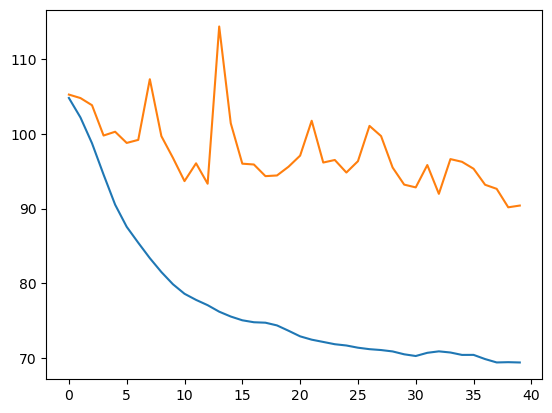

In [21]:
# plot the training and validation losses
plt.plot(history['train_losses'], label='Training Loss')
plt.plot(history['valid_losses'], label='Validation Loss')

# Inference test set

Plot the actual and predicted values and calculate the correlation

In [22]:
# function for a test loader predictions
def predict_loader(model, data_loader):
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    with torch.no_grad():
        for data, labels in tqdm(data_loader, desc='Batches'):
            images = data.cuda()
            targets = labels.cuda()
            # targets = torch.exp(targets)
            outputs = model(images)
            # outputs = torch.exp(outputs)
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(outputs.cpu().detach().numpy().tolist())
    return np.array(fin_outputs), np.array(fin_targets)


In [23]:
# load the best model
model = RetinaCNN()
model.load_state_dict(torch.load('../models/best_model_adv_3conv_batch_norm.pth'))
model.cuda()

RetinaCNN(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(8, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(32, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
  (fc): Linear(in_features=80000, out_features=9, bias=True)
  (bn4): BatchNorm1d(9, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
  (softplus): Softplus(beta=1.0, threshold=20.0)
)

In [24]:
predictions, targets = predict_loader(model, test_loader)

Batches: 100%|██████████| 3/3 [00:00<00:00,  9.26it/s]


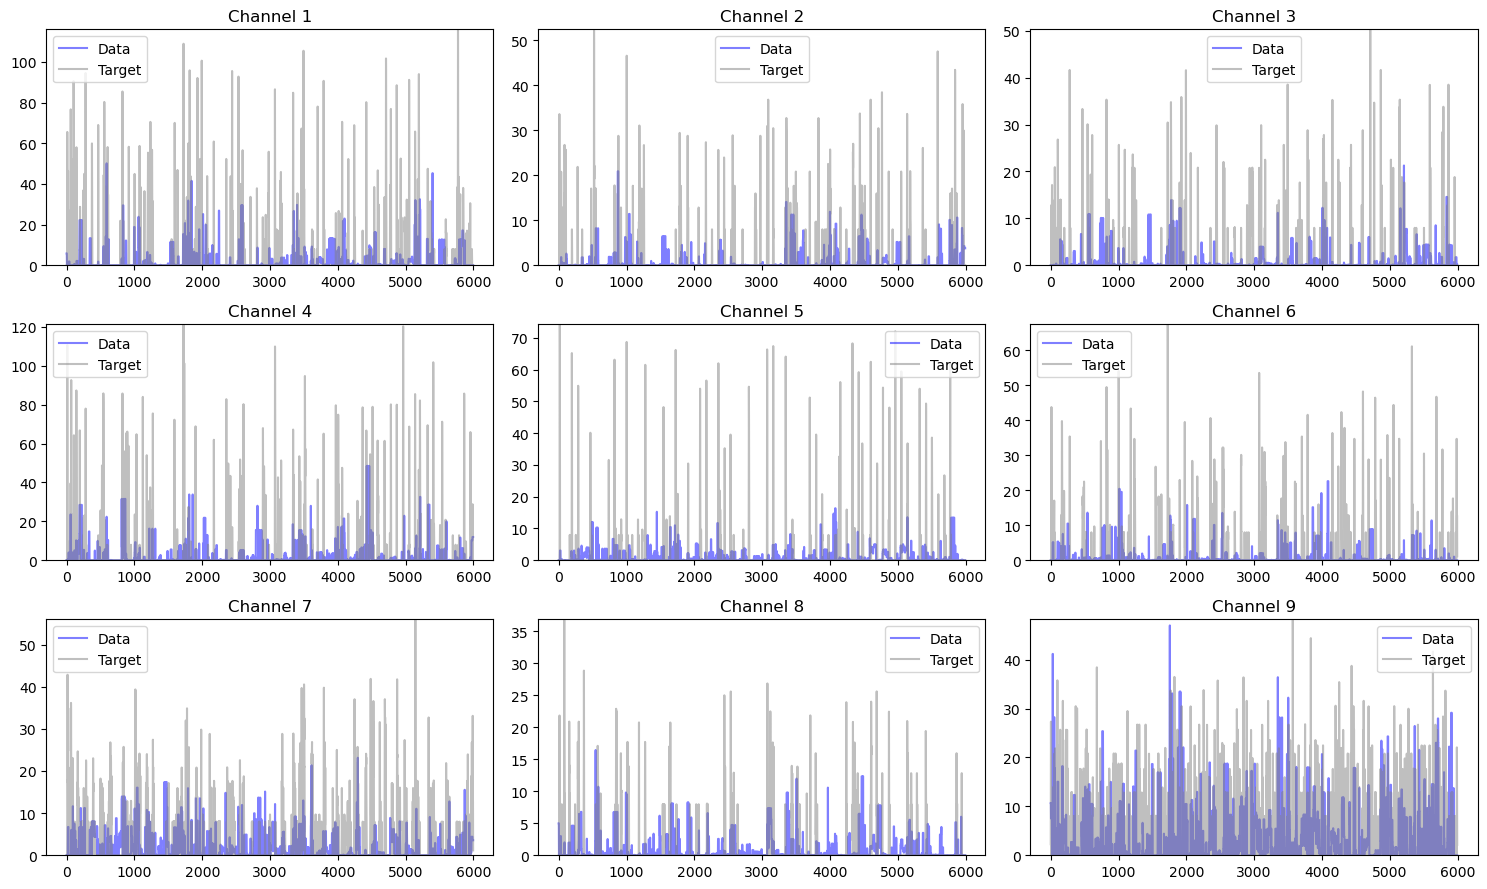

In [25]:
plot_time_series(np.transpose(predictions), np.transpose(targets))

In [32]:
max(np.transpose(predictions)[0])

3.4512012004852295